In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [6]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [7]:
params = {'n_steps': 3,
 'n_shared': 2,
 'n_independent': 1,
 'n_a': 21,
 'n_d': 21,
 'momentum': 0.02,
 'lr': 0.1,
 'lambda_sparse': 0.01,
 'gamma': 0.5,
 'clip_value': 1,
 'cat_emb_dim': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


params =  {#'batch_size': 1024,
 'cat_emb_dim': [5, 5, 5, 5, 5, 3, 5, 5, 1, 5, 4, 5, 3],
 'clip_value': 1,
 #'drop_last': False,
 'gamma': 1.7949255838988916,
 'lambda_sparse': 0.01894902609178557,
 'lr': 0.1,
 #'max_epochs': 1000,
 'momentum': 0.02209865986831315,
 'n_a': 37,
 'n_independent': 0,
 'n_shared': 0,
 'n_steps': 2,
 #'num_workers': 12,
 #'patience': 5,
 'verbose': 1,
 #'virtual_batch_size': 256,
 'n_d': 37}

In [8]:
clf = TabNetClassifier(cat_idxs=cat_idxs, cat_dims=cat_dims,
                       **params)

Device used : cuda


# Training

In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [10]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=1000 , patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=12,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.74884 |  0.83772 |   3.3       
| 2     | 0.86683 |  0.88288 |   5.5       
| 3     | 0.88942 |  0.88742 |   7.6       
| 4     | 0.89831 |  0.89862 |   9.8       
| 5     | 0.90212 |  0.89679 |   12.1      
| 6     | 0.90760 |  0.89913 |   14.3      
| 7     | 0.91499 |  0.91470 |   16.5      
| 8     | 0.91787 |  0.91783 |   18.8      
| 9     | 0.92102 |  0.91870 |   21.0      
| 10    | 0.92352 |  0.89347 |   23.1      
| 11    | 0.92488 |  0.92543 |   25.2      
| 12    | 0.92619 |  0.92800 |   27.4      
| 13    | 0.92633 |  0.92488 |   29.6      
| 14    | 0.92726 |  0.92228 |   31.8      
| 15    | 0.92760 |  0.92545 |   34.0      
| 16    | 0.93018 |  0.92108 |   36.2      
| 17    | 0.93064 |  0.92452 |   38.4      
| 18    | 0.93003 |  0.92977 |   40.7      
| 19    | 0.93130 |  0.93003 |   42.9      
| 20

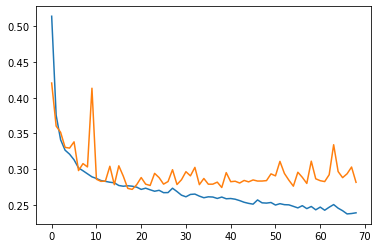

In [11]:
# plot losses
plt.plot(clf.history['train']['loss'])
plt.plot(clf.history['valid']['loss'])

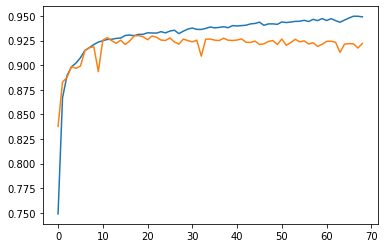

In [12]:
# plot auc
plt.plot([-x for x in clf.history['train']['metric']])
plt.plot([-x for x in clf.history['valid']['metric']])

### Predictions

In [13]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : -0.9300321551630452
FINAL TEST SCORE FOR census-income : 0.929152251345288


In [14]:
clf.network

TabNet(
  (embedder): EmbeddingGenerator(
    (embeddings): ModuleList(
      (0): Embedding(73, 5)
      (1): Embedding(9, 5)
      (2): Embedding(16, 5)
      (3): Embedding(16, 5)
      (4): Embedding(7, 5)
      (5): Embedding(15, 3)
      (6): Embedding(6, 5)
      (7): Embedding(5, 5)
      (8): Embedding(2, 1)
      (9): Embedding(119, 5)
      (10): Embedding(92, 4)
      (11): Embedding(94, 5)
      (12): Embedding(42, 3)
    )
  )
  (tabnet): TabNetNoEmbeddings(
    (initial_splitter): FeatTransformer(
      (specifics): GLU_Block(
        (glu_layers): ModuleList(
          (0): GLU_Layer(
            (fc): Linear(in_features=57, out_features=148, bias=False)
            (bn): GBN(
              (bn): BatchNorm1d(148, eps=1e-05, momentum=0.02209865986831315, affine=True, track_running_stats=True)
            )
          )
        )
      )
    )
    (feat_transformers): ModuleList(
      (0): FeatTransformer(
        (specifics): GLU_Block(
          (glu_layers): ModuleList

# Global explainability : feat importance summing to 1

In [15]:
clf.feature_importances_

array([2.44837809e-02, 1.59313784e-02, 0.00000000e+00, 1.45062530e-01,
       4.73338640e-02, 3.22095301e-01, 1.59118261e-04, 2.89352717e-01,
       6.93391014e-03, 3.37052229e-06, 1.11132372e-01, 0.00000000e+00,
       0.00000000e+00, 3.75116584e-02])

# Local explainability and masks

In [16]:
explain_matrix, masks = clf.explain(X_test)

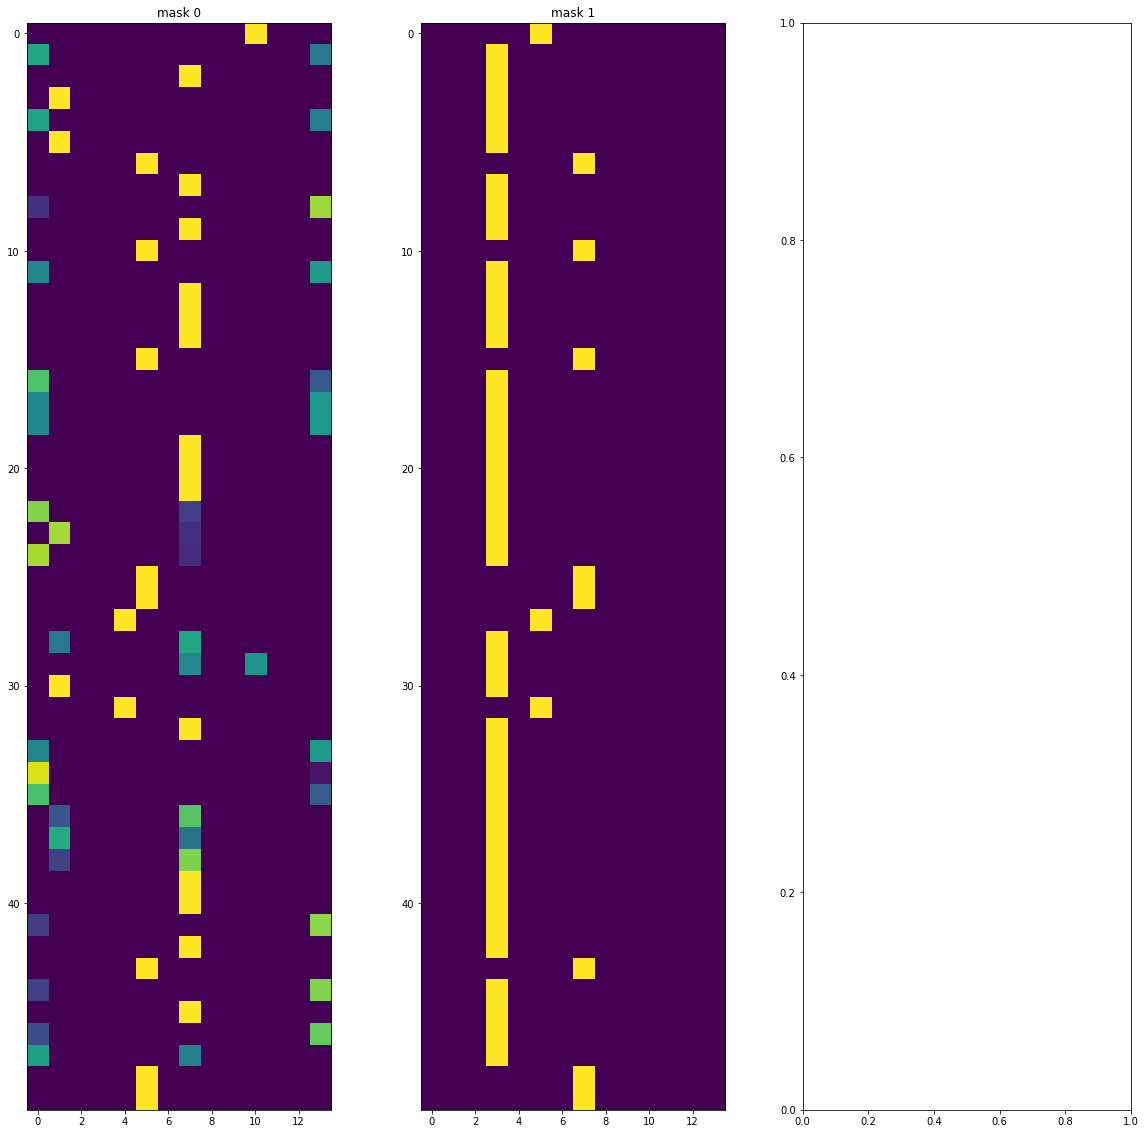

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(2):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [18]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.137845
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.129152
[20]	validation_0-error:0.126669
[30]	validation_0-error:0.124806
[40]	validation_0-error:0.124806
[50]	validation_0-error:0.124185
[60]	validation_0-error:0.124185
[70]	validation_0-error:0.124185
[80]	validation_0-error:0.124495
[90]	validation_0-error:0.123254
[100]	validation_0-error:0.122012
[110]	validation_0-error:0.121701
[120]	validation_0-error:0.122012
[130]	validation_0-error:0.122322
[140]	validation_0-error:0.122943
Stopping. Best iteration:
[103]	validation_0-error:0.12108



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=0)

In [19]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9335963387010509
0.9243623615745874
